# Move global forcing files to regional domain with new bathymetry

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/users/birgal/')
from nemo_python.grid import get_coast_mask, get_icefront_mask
from nemo_python.forcing import create_calving, subset_global, calving_at_coastline

### Main

In [74]:
domain_old   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-old.nc')
domain_new   = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20240123-filledlakes.nc')
mesh_new     = xr.open_dataset(f'/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20240123-filledlakes.nc')

#### general files

In [ ]:
folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/misc-forcing/'

# Internal wave field:
iwm_ds       = subset_global(f'{folder}eORCA025_iwm_b0.2_v1.0_nohls.nc'     , mesh_new, fill_ocn=True , time_counter=True)
# Bottom friction / turbulence:
shlat2d_ds   = subset_global(f'{folder}eORCA025_shlat2d_v0.2_nohls.nc'      , mesh_new, fill_ocn=False, time_counter=False)
bfr2d_ds     = subset_global(f'{folder}eORCA025_bfr2d_v0.2_nohls.nc'        , mesh_new, fill_ocn=False, time_counter=True)
# Distance to the coast:
distcoast_ds = subset_global(f'{folder}eORCA025_distcoast_b0.2_v0.0_nohls.nc', mesh_new, fill_ocn=True, time_counter=True)

#### empc and iceberg melt

In [76]:
# Iceberg melt forcing and empc
for month in range(1,13):
    ds  = xr.open_dataset(f'{folder}eORCA025.L121-OPM026_y1989m{month:02}.30y_flxT.nc').isel(y=slice(0,453), x=slice(1,1441))
    if month==1:
        var1 = ds.berg_melt
        var2 = ds.sowafld
    else:
        var1 = xr.concat([var1, ds.berg_melt], 'time_counter')
        var2 = xr.concat([var2, ds.sowafld]  , 'time_counter')

new_bergmelt = xr.Dataset({'berg_melt': var1}) # this has the files combined along the time dimension; didn't do anything about shifted coast
new_bergmelt.to_netcdf(f'{folder}AntArc_eORCA025_bergmelt.nc', unlimited_dims='time_counter')

new_empc = xr.Dataset({'sowafld': var2}) # this has the files combined along the time dimension; didn't do anything about shifted coast
new_empc.to_netcdf(f'{folder}AntArc_eORCA025_empc.nc', unlimited_dims='time_counter')

#### runoff

In [81]:
# check to see whether runoff needs to be moved closer to the coastline
rnf = xr.open_dataset(f'{folder}eORCA025_runoff_b0.2_v0.0_nohls.nc').isel(y=slice(0,453))

In [78]:
# Runoff seems zero everywhere except at the few cells where I extended the domain, so fill with zeros for now
rnf_new = rnf.copy()
rnf_new['socoefr']  = ('y','x'), np.zeros(rnf['socoefr'].values.shape) 
rnf_new['sorunoff'] = ('time_counter','y','x'), np.zeros(rnf['sorunoff'].values.shape)
rnf_new.to_netcdf(f'{folder}AntArc_eORCA025_runoff_b0.2_v0.0_nohls.nc', unlimited_dims='time_counter')

#### calving

In [79]:
calving  = xr.open_dataset(f'{folder}eORCA025_calving_b0.2_v2.3_nohls.nc').isel(time_counter=0, y=slice(0,453))
calv_new = create_calving(mesh_new, f'{folder}eORCA025_calving_b0.2_v2.3_nohls.nc')

In [80]:
# for visualization:
calving_ocn, calving_land, calving_ice = calving_at_coastline(calving.soicbclv, mesh_new)

x, y      = np.meshgrid(mesh_new.nav_lon.x, mesh_new.nav_lon.y)
calving_x = np.ma.masked_where(calving.soicbclv.values==0, x)
calving_y = np.ma.masked_where(calving.soicbclv.values==0, y)

coast_mask        = get_coast_mask(mesh_new)
icefront_mask_ice = get_icefront_mask(mesh_new, side='ice')
icefront_mask_ocn = get_icefront_mask(mesh_new, side='ocean')
calving_nonocnx = np.ma.masked_where(icefront_mask_ocn, calving_x)
calving_nonocny = np.ma.masked_where(icefront_mask_ocn, calving_y)
calving_newx    = np.ma.masked_where(np.isnan(calv_new.soicbclv.isel(time_counter=0).values),  calving_x)
calving_newy    = np.ma.masked_where(np.isnan(calv_new.soicbclv.isel(time_counter=0).values),  calving_y)

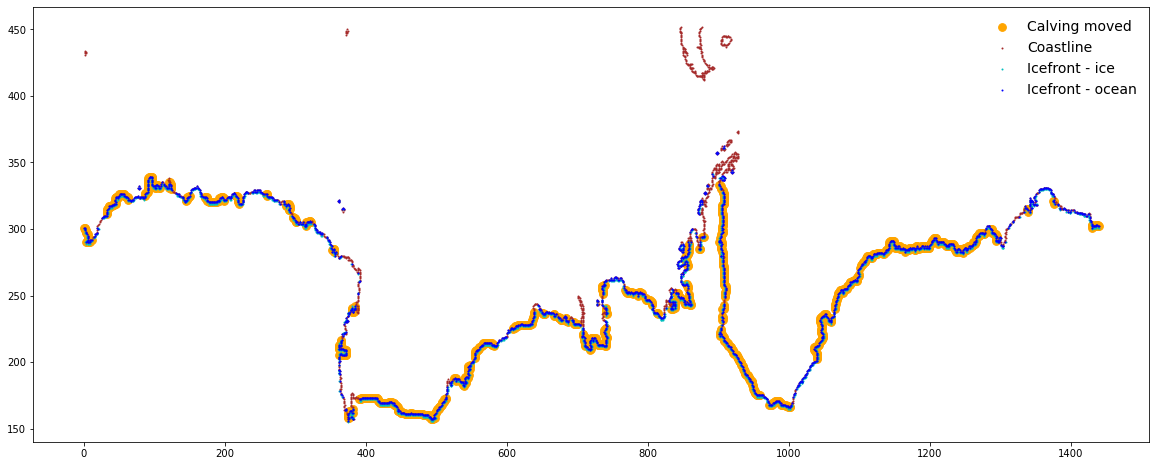

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20,8))

coast_x  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, x); 
coast_y  = np.ma.masked_where(coast_mask.isel(nav_lev=0) == 0, y);
isfice_x = np.ma.masked_where(icefront_mask_ice == 0, x); isfice_y = np.ma.masked_where(icefront_mask_ice == 0, y);
isfocn_x = np.ma.masked_where(icefront_mask_ocn == 0, x); isfocn_y = np.ma.masked_where(icefront_mask_ocn == 0, y);
ax.scatter(calving_newx  , calving_newy  , c='orange', s=60, edgecolor='orange', label='Calving moved');
ax.scatter(coast_x , coast_y , c='brown', s=1, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c', s=1, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b', s=1, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

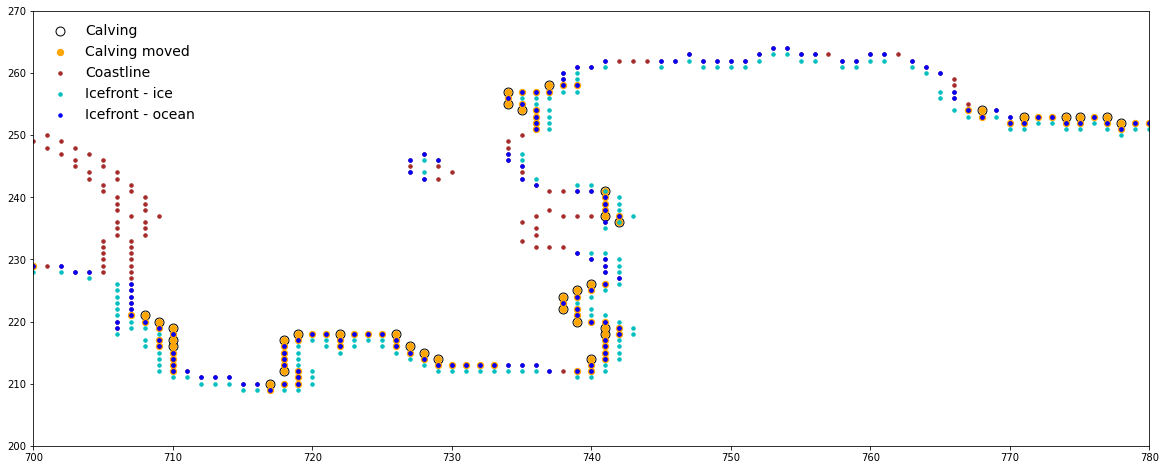

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.set_xlim(700,780)
ax.set_ylim(200,270)

ax.scatter(calving_nonocnx, calving_nonocny, c='w'     , s=80, edgecolor='k', label='Calving');
ax.scatter(calving_newx   , calving_newy   , c='orange', s=40, edgecolor='orange', label='Calving moved');
ax.scatter(coast_x , coast_y , c='brown', s=12, label='Coastline');
ax.scatter(isfice_x, isfice_y, c='c'    , s=12, label='Icefront - ice');
ax.scatter(isfocn_x, isfocn_y, c='b'    , s=12, label='Icefront - ocean');

ax.legend(frameon=False, fontsize=14)

In [ ]:
# tiny patches of floating ice shelves --- keep??